In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.pyplot import figure

import seaborn as sns
sns.set_theme(style="ticks", color_codes=True)

from collections import Counter, defaultdict

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
# from sklearn import manifold

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier,\
VotingClassifier, StackingClassifier


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from xgboost import XGBRFClassifier, XGBClassifier

from sklearn import metrics

from scipy.stats import sem, t
from scipy import mean


In [2]:
df = pd.read_csv('daily data.csv')
df.head()

,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,solarenergy,uvindex,pm25,pm10,o3,no2,so2,pollen_intensity,admission number,risk level
0,2019-01-01,16.0,7.6,11.5,16.0,6.6,11.4,5.1,66.2,0.000,...,10.3,5,0.0,19.0,12.0,22.0,1.0,good,5,high risk
1,2019-01-02,15.9,7.6,10.9,15.9,6.2,10.5,7.4,80.2,0.000,...,4.8,3,0.0,0.0,0.0,0.0,0.0,good,3,high risk
2,2019-01-03,10.3,4.5,7.4,10.3,2.2,6.3,6.1,91.7,0.005,...,10.2,5,45.0,15.0,27.0,9.0,0.0,good,1,low risk
3,2019-01-04,13.1,6.6,9.7,13.1,4.1,8.7,6.9,84.1,0.000,...,8.8,5,57.0,18.0,28.0,23.0,1.0,good,5,high risk
4,2019-01-05,14.8,7.8,10.5,14.8,6.0,9.9,5.5,71.4,0.000,...,11.1,5,43.0,18.0,29.0,12.0,0.0,good,2,low risk


In [3]:
df.columns

Index(['datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'windspeed', 'sealevelpressure', 'cloudcover',
       'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'pm25',
       'pm10', 'o3', 'no2', 'so2', 'pollen_intensity', 'admission number',
       'risk level'],
      dtype='object')

# Preprocessing

In [4]:
# toDrop = ['data_admissao', 'dicofre', 'distrito', 'concelho', 'freguesia', 'regiao', 'nacionalidade',
#          'cod_proveniencia', 'proveniencia', 'cod_causa', 'causa', 'cod_destino', 'destino',
#          'diagnostico', 'classe', 'asma', 'date', 'name','snow', 'snowdepth', 'winddir', 'cor',
#          'severerisk', 'sunrise', 'sunset', 'stations', 'icon', 'description', 'preciptype',
#          'moonphase', 'windgust', 'feelslikemax', 'feelslikemin', 'feelslike', 'uvindex', 'dew',
#          'precipprob', 'precip',
#          'precipcover', 'visibility', 'solarradiation', 'solarenergy', 'sealevelpressure',
#           'cloudcover']
toDrop = ['windgust']

In [5]:
for col in df:
    if col  in toDrop:
        df.drop(col, axis=1, inplace=True)

In [6]:
# # conditions
# # pollen_intensity

# # Get one hot encoding of columns conditions
# one_hot = pd.get_dummies(df['conditions'])
# # Drop column conditions as it is now encoded
# df = df.drop('conditions',axis = 1)
# # Join the encoded df
# df = df.join(one_hot)
# df

In [7]:
for i in range(len(df['pollen_intensity'])):
    if df.loc[i, 'pollen_intensity'] == 'good':
        df.loc[i, 'pollen_intensity'] = 1
    elif df.loc[i, 'pollen_intensity'] == 'baixos':
        df.loc[i, 'pollen_intensity'] = 2
    elif df.loc[i, 'pollen_intensity'] == 'elevados':
        df.loc[i, 'pollen_intensity'] = 3
    elif df.loc[i, 'pollen_intensity'] == 'muito elevados':
        df.loc[i, 'pollen_intensity'] = 4
df['pollen_intensity'].value_counts()

1            565
4            123
moderados     45
2             28
3             28
Name: pollen_intensity, dtype: int64

In [8]:
## Adding feature
df['tem amplitude'] = df['tempmax'] - df['tempmin']
df.drop(['tempmax', 'tempmin'], axis=1, inplace=True)

In [9]:
X = pd.DataFrame()
for col in df.columns:
    try:
        df[col] = df[col].astype(float)
        X[col] = df[col]
    except:
        print(col)
X.drop(['admission number'], axis=1, inplace=True)
# X

datetime
pollen_intensity
risk level


In [10]:
scaler = MinMaxScaler()
xcolumns = X.columns
X = pd.DataFrame(X, columns=xcolumns)

In [11]:
# tempChange = []
# for i in range(len(X)):
#     try:
# #         print(X.loc[i, 'temp'] , X.loc[i-1, 'temp'],(X.loc[i, 'temp'] - X.loc[i-1, 'temp']))
#         tempChange.append((X.loc[i, 'temp'] - X.loc[i-1, 'temp']))
# #         break
#     except:
#         tempChange.append(0)
        
# X['temp cahnge'] = tempChange

# X[['tem amplitude', 'admission number', 'temp cahnge', 'temp', 'humidity']].corr()

In [12]:
# tempChange2 = []
# for i in range(len(X)):
#     try:
# #         print(X.loc[i, 'temp'] , X.loc[i-1, 'temp'],(X.loc[i, 'temp'] - X.loc[i-1, 'temp']))
#         tempChange2.append((X.loc[i, 'temp'] - X.loc[i-2, 'temp']))
# #         break
#     except:
#         tempChange2.append(0)
        
# X['temp cahnge2'] = tempChange2

# X.plot.scatter('temp cahnge2', 'admission number')


In [13]:
# X['risk level'] = [1 if risk=='low risk' else 2 if risk=='moderate risk' else 3 for risk in df['risk level']]
# X.to_csv('daily data1.csv', index=False)

In [14]:
y = [0 if risk=='low risk'  else 1 for risk in df['risk level']]

Counter(y)
# y = []
# for risk in df['risk level']:


Counter({1: 300, 0: 489})

In [15]:
y1 = df['admission number']

## feature selection

In [16]:
# High risk vs low risk
'''
feelslikemax                -0.28655    0.13398  -2.139  0.03246 * 
pollen_intensity             0.24799    0.13148   1.886  0.05928 . 
DiÃ³xido.de.Azoto..Âµg.m3.   0.06427    0.01993   3.224  0.00126 **
MonÃ³xido.de.Azoto..Âµg.m3. -0.14974    0.05755  -2.602  0.00927 **
visibility                  -0.19235    0.12487  -1.540  0.12346   
tem                          0.22348    0.15804   1.414  0.15732 '''

# moderate risk vs low risk
'''
feelslikemax -0.06283    0.02579  -2.436  0.01486 * 
precip        0.23396    0.08820   2.653  0.00799 **
precipcover  -0.04477    0.01427  -3.139  0.00170 **'''


# High risk vs low moderate
'''
precipprob        0.008830   0.002975   2.968   0.0030 **
dew              -0.069355   0.036408  -1.905   0.0568 . 
pollen_intensity  0.181718   0.116083   1.565   0.1175   '''

# X = X[['feelslikemax','pollen_intensity', 'Dióxido de Azoto (µg/m3)','Monóxido de Azoto (µg/m3)', 'visibility', 
# 'temp', 'feelslikemax', 'precip', 'precipcover', 'precipprob', 'dew', 'pollen_intensity']]


'\nprecipprob        0.008830   0.002975   2.968   0.0030 **\ndew              -0.069355   0.036408  -1.905   0.0568 . \npollen_intensity  0.181718   0.116083   1.565   0.1175   '

In [17]:
X.isna().sum()

temp                0
feelslikemax        0
feelslikemin        0
feelslike           0
dew                 0
humidity            0
precip              0
precipprob          0
precipcover         0
windspeed           0
sealevelpressure    0
cloudcover          0
visibility          0
solarradiation      0
solarenergy         0
uvindex             0
pm25                0
pm10                0
o3                  0
no2                 0
so2                 0
tem amplitude       0
dtype: int64

In [18]:
X.iloc[:, :10].describe()

,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,precipcover,windspeed
count,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000
mean,17.247022,21.523574,13.622814,17.148669,11.156907,70.429785,1.298902,35.234474,7.784233,21.808492
std,4.440087,5.360165,4.422822,4.502068,4.174149,14.820836,4.376301,47.800368,15.484074,6.129664
min,7.400000,10.300000,2.200000,6.200000,-3.200000,21.600000,0.000000,0.000000,0.000000,7.400000
25%,13.700000,17.100000,10.800000,13.600000,8.400000,61.500000,0.000000,0.000000,0.000000,17.800000
50%,16.600000,20.600000,13.600000,16.600000,11.000000,71.200000,0.000000,0.000000,0.000000,21.600000
75%,20.600000,25.600000,17.200000,20.600000,14.700000,80.800000,0.118000,100.000000,8.330000,25.100000
max,31.800000,37.900000,26.300000,30.200000,21.000000,99.300000,51.314000,100.000000,87.500000,59.000000


In [19]:
# x_train = x_train.drop(['dew'], axis=1)
# x_test = x_test.drop(['dew'], axis=1)

In [20]:
y = pd.DataFrame(y)


In [21]:
x_train, x_test = X.iloc[:int(len(X)*.8), :], X.iloc[int(len(X)*.8):, :]
y_train, y_test = y.iloc[:int(len(X)*.8), :], y.iloc[int(len(X)*.8):, :]

x_train = pd.DataFrame(x_train, columns=X.columns)
lenTrain = len(x_train)
x_test = pd.DataFrame(x_test, columns=X.columns)

In [22]:
from sklearn.feature_selection import chi2

# #scaller
# scaler = MinMaxScaler()
# X = X.drop(['admission number'], axis=1)
columns = x_train.drop(['dew'], axis=1).columns
# X = scaler.fit_transform(X)


In [23]:
# Calculating Fscore and p value
f_p_values = chi2(x_train.drop(['dew'], axis=1), y_train)
chi2_f_p_values = pd.DataFrame(f_p_values, columns=columns, index=['F_score', 'P_value']).\
T.sort_values('P_value',ascending=True).round(2)
chi2_f_p_values[chi2_f_p_values['P_value'] < 0.16].index
#[chi2_f_p_values['P_value'] < 0.5]

Index(['precipprob', 'solarradiation', 'precipcover', 'solarenergy', 'precip',
       'so2', 'pm25', 'uvindex', 'feelslikemax', 'no2', 'feelslike',
       'humidity', 'temp', 'feelslikemin', 'tem amplitude', 'windspeed',
       'cloudcover'],
      dtype='object')

In [24]:
chi2_f_p_values

,F_score,P_value
precipprob,539.49,0.00
solarradiation,383.36,0.00
precipcover,100.08,0.00
solarenergy,34.11,0.00
precip,25.60,0.00
so2,16.53,0.00
pm25,13.07,0.00
uvindex,12.95,0.00
feelslikemax,12.58,0.00
no2,10.41,0.00


In [25]:
from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
mutual_info = mutual_info_classif(x_train, y_train)
columns = x_train.columns
mutual_info = pd.DataFrame(mutual_info, index=columns, columns=['mutual_info']).\
                sort_values('mutual_info',ascending=False)
mutual_info

c:\program files\python38\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,mutual_info
pm10,0.044772
humidity,0.043226
no2,0.036100
tem amplitude,0.035727
pm25,0.015980
feelslikemin,0.013530
uvindex,0.013154
solarradiation,0.009021
cloudcover,0.007805
solarenergy,0.002443


In [27]:
##Removing features with low variance
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(x_train)

array([[11.5, 16. ,  6.6, ..., 22. ,  1. ,  8.4],
       [10.9, 15.9,  6.2, ...,  0. ,  0. ,  8.3],
       [ 7.4, 10.3,  2.2, ...,  9. ,  0. ,  5.8],
       ...,
       [18.4, 22.3, 16.2, ..., 11. ,  0. ,  6.1],
       [19.4, 23. , 16.6, ..., 13. ,  0. ,  6.4],
       [18.8, 22.1, 15.7, ...,  4. ,  0. ,  6.4]])

In [28]:
#L1-based feature selection
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(x_train, y_train)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(x_train)
X_new.shape

c:\program files\python38\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\program files\python38\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(631, 11)

In [29]:
# ##Recursive feature elimination

# from sklearn.svm import SVC
# from sklearn.feature_selection import RFE
# import matplotlib.pyplot as plt



# # Create the RFE object and rank each pixel
# svc = SVC(kernel="linear", C=1)
# rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
# rfe.fit(x_train, y_train)


In [30]:
# ranking = pd.DataFrame( rfe.ranking_, index=columns, columns=['ranking']).sort_values('ranking',ascending=True)
# ranking

In [31]:
# ## Recursive feature elimination with cross-validation
# import matplotlib.pyplot as plt
# from sklearn.svm import SVC
# from sklearn.model_selection import StratifiedKFold
# from sklearn.feature_selection import RFECV
# from sklearn.datasets import make_classification


# # Create the RFE object and compute a cross-validated score.
# svc = SVC(kernel="linear")
# # The "accuracy" scoring shows the proportion of correct classifications

# min_features_to_select = 1  # Minimum number of features to consider
# rfecv = RFECV(
#     estimator=svc,
#     step=1,
#     cv=StratifiedKFold(2),
#     scoring="accuracy",
#     min_features_to_select=min_features_to_select,
# )
# rfecv.fit(x_train, y_train)

# print("Optimal number of features : %d" % rfecv.n_features_)


In [32]:
# # Plot number of features VS. cross-validation scores
# figure(figsize=(12, 8))
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (accuracy)")
# plt.plot(
#     range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
#     rfecv.grid_scores_,
# )
# plt.legend(['train', 'test'])
# plt.show()

In [33]:
# Extra tree feature selection
model = ExtraTreesClassifier( n_jobs=-1)
model

ExtraTreesClassifier(n_jobs=-1)

C:\Users\Akhod\AppData\Local\Temp\ipykernel_4964\3340126244.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


Train accuracy: 0.6518987341772152
              precision    recall  f1-score   support

           0       0.70      0.84      0.77       107
           1       0.43      0.25      0.32        51

    accuracy                           0.65       158
   macro avg       0.57      0.55      0.54       158
weighted avg       0.62      0.65      0.62       158



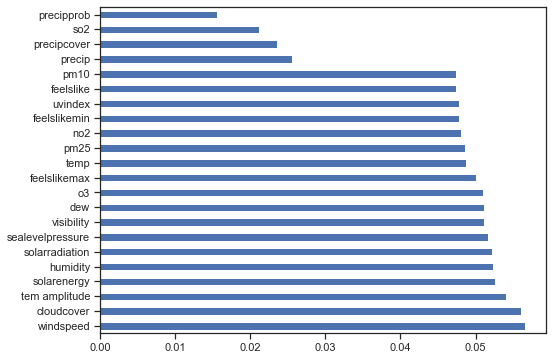

In [34]:
model.fit(x_train, y_train)
predict = model.predict(x_test)

###Metrics
print("Train accuracy:",metrics.accuracy_score(y_test, predict))
print(classification_report(y_test, predict))

# print("Test R^2:",metrics.r2_score(y_test, predict))

matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

# print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=x_train.columns)
feat_importances.nlargest(22).plot(kind='barh')
plt.show()
# feat_importances = pd.DataFrame(feat_importances.nlargest(25))
# len(feat_importances.index)


In [35]:
feat_importances[feat_importances > 0.02].index

Index(['temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity',
       'precip', 'precipcover', 'windspeed', 'sealevelpressure', 'cloudcover',
       'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'pm25',
       'pm10', 'o3', 'no2', 'so2', 'tem amplitude'],
      dtype='object')

In [36]:
## feature importances from ExtraTree
x_train = x_train[list(feat_importances[feat_importances > 0.02].index)]
x_test  = x_test [list(feat_importances[feat_importances > 0.02].index)]

In [ ]:
list(mutual_info[mutual_info['mutual_info']>0.02].index

In [37]:
## Feature selection from mutual information
x_train = x_train[list(mutual_info[mutual_info['mutual_info']>0.02].index)]
x_test  = x_test [list(mutual_info[mutual_info['mutual_info']>0.02].index)]

In [38]:
## Feature selection from chi2
# x_train = x_train[list(chi2_f_p_values[chi2_f_p_values['P_value'] < 0.025].index)]
# x_test  = x_test [list(chi2_f_p_values[chi2_f_p_values['P_value'] < 0.025].index)]

## prepocessing

In [39]:
# ########## PCA of visualization
# pca_model = PCA(n_components=2)
# x_train = pca_model.fit_transform(x_train)
# x_test = pca_model.transform(x_test)

In [40]:
# clf = DecisionTreeClassifier()
# # iris = load_iris()
# cross_val_score(clf, X, y, cv=10)


# Model tuning

In [41]:
y_train = y_train.values.ravel()

### Gaussian Naive Bayes

In [45]:
nb_classifier = GaussianNB()

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
# print(params_NB)


tscv = TimeSeriesSplit(n_splits=3)
gs_NB = GridSearchCV(estimator=nb_classifier, param_grid=params_NB,
                     cv=tscv, scoring='f1_weighted', verbose=1, n_jobs=-1)

gs_NB.fit(x_train, y_train)
print('f1_weighted: %.3f' % gs_NB.best_score_)

print('Config: %s' % gs_NB.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
f1_weighted: 0.577
Config: {'var_smoothing': 0.23101297000831597}


### Linear Discriminant Analysis

In [43]:
from numpy import arange
# define model
lda = LinearDiscriminantAnalysis()

# define grid
LDA_param = dict()
LDA_param['solver'] = ['svd', 'lsqr', 'eigen']
LDA_param['shrinkage'] = arange(0, 1, 0.01)

tscv = TimeSeriesSplit(n_splits=3)
gs_LDA = GridSearchCV(estimator=lda, param_grid=LDA_param,
                     cv=tscv, scoring='f1_weighted', verbose=0, n_jobs=-1)

gs_LDA.fit(x_train, y_train)

gs_LDA.best_params_
# summarize
print('f1_weighted: %.3f' % gs_LDA.best_score_)
print('Config: %s' % gs_LDA.best_params_)

f1_weighted: 0.536
Config: {'shrinkage': 0.74, 'solver': 'lsqr'}


c:\program files\python38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
300 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "c:\program files\python38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\program files\python38\lib\site-packages\sklearn\discriminant_analysis.py", line 583, in fit
    raise NotImplementedError("shrinkage not supported")
NotImplementedError: shrinkage not supported

  warnings.warn(some_fits_failed_message, FitFailedWarning)
c:\program files\python38\lib\site-pac

### DT model tuning

In [44]:
DT = DecisionTreeClassifier()

criterion = ['gini', 'entropy']
max_depth =  list(range(3, 20, 5))
max_features = list(range(4 , x_train.shape[1]))
min_samples_leaf = list(range(1, 31, 3))
min_samples_split = list(range(2, 10, 2))
# presort = [False, True]

DT_param = {'criterion': criterion,
               'max_depth': max_depth,
               'max_features': max_features,
               'min_samples_leaf': min_samples_leaf,
               'min_samples_split': min_samples_split}

tscv = TimeSeriesSplit(n_splits=3)
DT_grid = GridSearchCV(estimator = DT, param_grid = DT_param, 
                       cv=tscv, scoring='f1_weighted', verbose=1, n_jobs=-1)
# fitting the model for grid search 
DT_grid.fit(x_train , y_train)
DT_grid.best_params_
# summarize
print('f1_weighted: %.3f' % DT_grid.best_score_)
print('Config: %s' % DT_grid.best_params_)

Fitting 3 folds for each of 5440 candidates, totalling 16320 fits
f1_weighted: 0.606
Config: {'criterion': 'gini', 'max_depth': 13, 'max_features': 6, 'min_samples_leaf': 7, 'min_samples_split': 6}


### SVC Model tuning

In [46]:
# defining parameter range for SVM
svc = SVC()
SVC_param_grid = {'C': [0.1, 1, 10, 100, 1000],  
                  'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
                  'kernel': ['rbf','sigmoid', 'linear']}

# , 'poly'
tscv = TimeSeriesSplit(n_splits=3)
SVC_clf = GridSearchCV(svc, SVC_param_grid, cv=tscv, scoring='f1_weighted',
                   verbose = 3, n_jobs = -1)
SVC_clf.fit(x_train, ( y_train))
print('f1_weighted: %.3f' % SVC_clf.best_score_)

SVC_clf.best_params_

Fitting 3 folds for each of 75 candidates, totalling 225 fits
f1_weighted: 0.557


{'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}

### Logistic Regression

In [47]:
LR = LogisticRegression()
LRparam_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'max_iter': list(range(100,400,100)),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}
tscv = TimeSeriesSplit(n_splits=3)

LR_search = GridSearchCV(LR, param_grid=LRparam_grid, cv=tscv, scoring='f1_weighted',
                   verbose = 0, n_jobs = -1)

# fitting the model for grid search \
LR_search.fit(x_train , y_train)
LR_search.best_params_
# summarize
print('f1_weighted: %.3f' % LR_search.best_score_)
print('Config: %s' % LR_search.best_params_)

f1_weighted: 0.566
Config: {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}


c:\program files\python38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
189 fits failed out of a total of 630.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
63 fits failed with the following error:
Traceback (most recent call last):
  File "c:\program files\python38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\program files\python38\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\program files\python38\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError

### Gradient Boosting

In [ ]:
GB = GradientBoostingClassifier()
param_GB = {
#     'learning_rate': [0.5, 0.25, 0.1, 0.05, 0.01],
    'n_estimators':range(10,100,10),
    'max_depth':range(1, 20, 1),
#     'min_samples_split':list(range(5, 31, 5)),
#     'min_samples_leaf':range(20,80,20),
    'max_features':range(2, x_train.shape[1]-10,1)
}
tscv = TimeSeriesSplit(n_splits=3)

GB_search = GridSearchCV(estimator = GB, param_grid = param_GB, cv=tscv, scoring='f1_weighted',
                   verbose = 1, n_jobs = -1)

# fitting the model for grid search 
GB_search.fit(x_train , y_train)
# GB_search.best_params_
# summarize
print('f1_weighted: %.3f' % GB_search.best_score_)
print('Config: %s' % GB_search.best_params_)

### XGBosst Classifier

In [ ]:
GB = GradientBoostingClassifier()
param_GB = {
#     'learning_rate': [0.5, 0.25, 0.1, 0.05, 0.01],
    'n_estimators':range(10,100,10),
    'max_depth':range(1, 10, 1),
#     'min_samples_split':list(range(5, 31, 5)),
#     'min_samples_leaf':range(20,80,20),
    'max_features':range(5, x_train.shape[1],1)
}

GB_search = GridSearchCV(es timator = GB, param_grid = param_GB, cv=tscv, scoring='f1_weighted',
                   verbose = 1, n_jobs = -1)

# fitting the model for grid search 
GB_search.fit(x_train , y_train)
# GB_search.best_params_
# summarize
print('f1_weighted: %.3f' % GB_search.best_score_)
print('Config: %s' % GB_search.best_params_)

### RFXGBoost Classifier

In [ ]:
GB = GradientBoostingClassifier()
param_GB = {
#     'learning_rate': [0.5, 0.25, 0.1, 0.05, 0.01],
    'n_estimators':range(10,100,10),
    'max_depth':range(1, 10, 1),
#     'min_samples_split':list(range(5, 31, 5)),
#     'min_samples_leaf':range(20,80,20),
    'max_features':range(5, x_train.shape[1],1)
}

GB_search = GridSearchCV(es timator = GB, param_grid = param_GB, cv=tscv, scoring='f1_weighted',
                   verbose = 0, n_jobs = -1)

# fitting the model for grid search 
GB_search.fit(x_train , y_train)
# GB_search.best_params_
# summarize
print('f1_weighted: %.3f' % GB_search.best_score_)
print('Config: %s' % GB_search.best_params_)

### RF model tuning

In [ ]:
'Random Forest'
## Using grid search
rf = RandomForestClassifier()
# Number of trees in random forest
n_estimators = [int(x) for x in range(100, 300, 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in range(4, x_train.shape[1]-10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 6, 8, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

tscv = TimeSeriesSplit(n_splits=3)
RF_clf = GridSearchCV(rf, random_grid, cv=tscv, scoring='f1_weighted',
                   verbose=1, n_jobs=-1)
 
# fitting the model for grid search 
RF_clf .fit(x_train , y_train)
RF_clf .best_params_

Fitting 3 folds for each of 2560 candidates, totalling 7680 fits


# Model training

In [39]:
# xtrian, xtext, ytrain, ytest = train_test_split(X, y, test_size=0.2)
# clf.fit(xtrian, ytrain)
# y_pred = clf.predict(xtext)
# confusion_matrix(ytest, y_pred)

In [41]:
y = pd.DataFrame(y)

In [42]:
# tscv = TimeSeriesSplit(n_splits=3)
# print(tscv)
# TimeSeriesSplit(max_train_size=None, n_splits=3)
# for train_index, test_index in tscv.split(X.values):
# #     print('TRAIN:', train_index, 'TEST:', test_index) 
#     X_train, X_test = X.loc[train_index], X.loc[test_index]
#     y_train, y_test = y.loc[train_index], y.loc[test_index]
#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
#     print(confusion_matrix(y_test, y_pred))
#     print(classification_report(y_test, y_pred))

In [43]:
clDT = DecisionTreeClassifier()
tscv = TimeSeriesSplit(max_train_size=None, n_splits=len(X)-1)

print(tscv)
DTpred = []
DTerror = []
i = 0
for train_index, test_index in tscv.split(X.values):
    if len(train_index) < lenTrain:
        continue
    Xtrain, Xtest = X.loc[train_index], X.loc[test_index]
    ytrain, ytest = y.loc[train_index], y.loc[test_index]
    
    #scaller
    Xtrain = scaler.fit_transform(Xtrain)
    Xtest = scaler.transform(Xtest)
    
    #fit the model
    clDT.fit(Xtrain, ytrain)
    y_pred = clDT.predict(Xtest)
#     print(y_test , y_pred,  y_test- y_pred)
    DTpred.append(y_pred[0])
    DTerror.append(ytest - y_pred[0])
    i += 1


TimeSeriesSplit(gap=0, max_train_size=None, n_splits=455, test_size=None)


DT accuracy 0.5434782608695652
              precision    recall  f1-score   support

           0       0.62      0.60      0.61        55
           1       0.44      0.46      0.45        37

    accuracy                           0.54        92
   macro avg       0.53      0.53      0.53        92
weighted avg       0.55      0.54      0.55        92

DT MSE 0.45652173913043476


C:\Users\Akhod\AppData\Local\Temp\ipykernel_1108\2568564487.py:4: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  print('DT MSE', mean([np.power(er, 2) for er in DTerror]))


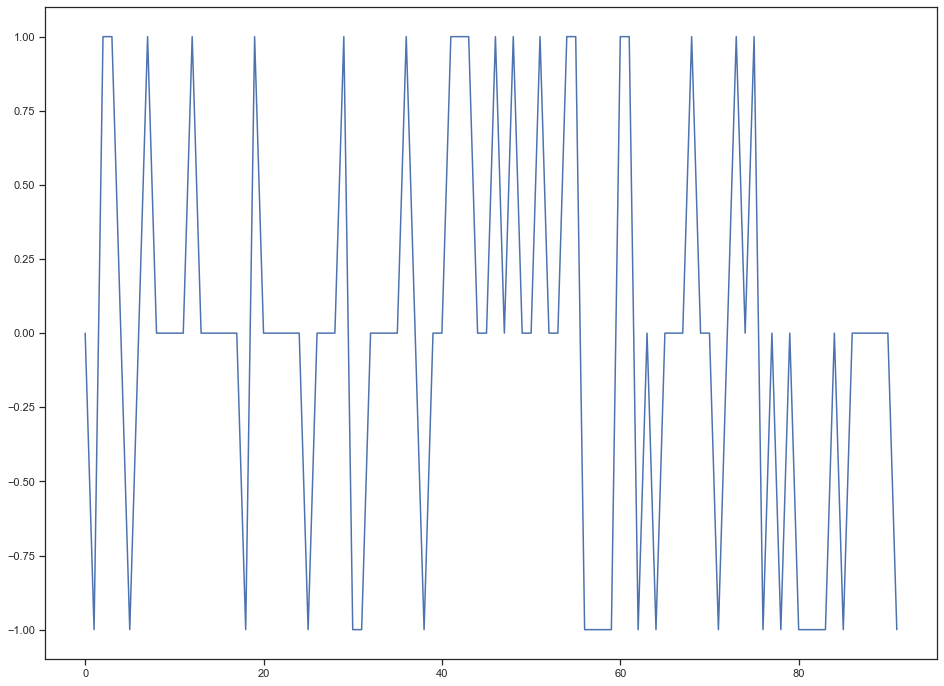

In [44]:
print('DT accuracy', metrics.accuracy_score(y_test, DTpred))
print(classification_report(y_test, DTpred))

print('DT MSE', mean([np.power(er, 2) for er in DTerror]))
figure(figsize=(16, 12))

plt.plot([er[0] for er in DTerror])

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=455, test_size=None)
DT accuracy 0.5543478260869565
              precision    recall  f1-score   support

           0       0.64      0.58      0.61        55
           1       0.45      0.51      0.48        37

    accuracy                           0.55        92
   macro avg       0.55      0.55      0.55        92
weighted avg       0.56      0.55      0.56        92

DT MSE 0.44565217391304346


C:\Users\Akhod\AppData\Local\Temp\ipykernel_1108\2725670304.py:32: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  print('DT MSE', mean([np.power(er, 2) for er in DTerror]))


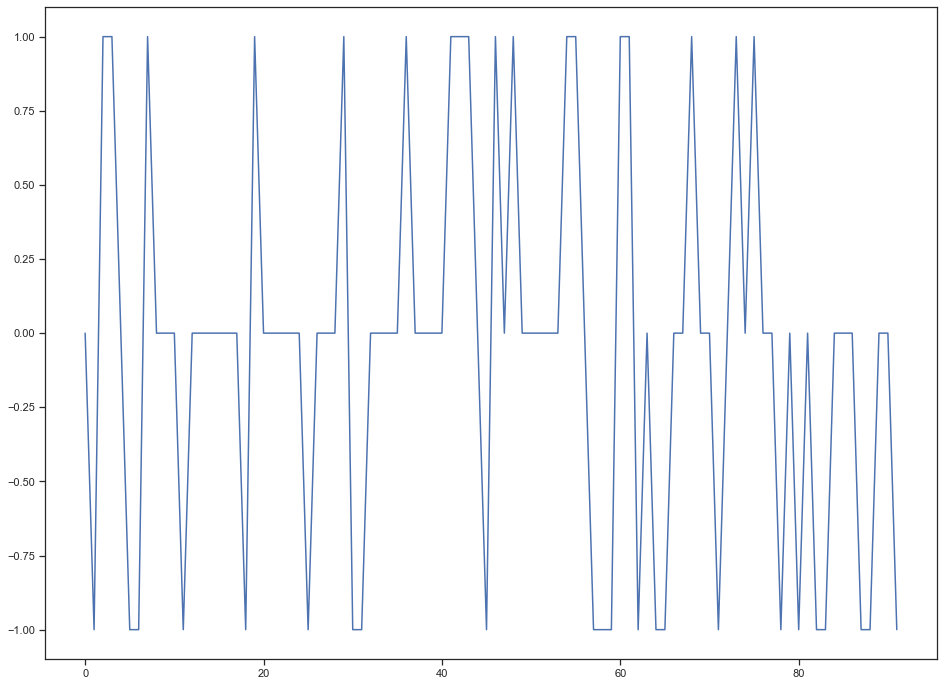

In [45]:
clDT = DecisionTreeClassifier ()
tscv = TimeSeriesSplit(max_train_size=None, n_splits=len(X)-1)

print(tscv)
DTpred = []
DTerror = []
i = 0
for train_index, test_index in tscv.split(X.values):
    if len(train_index) < lenTrain:
        continue
    Xtrain, Xtest = X.loc[train_index], X.loc[test_index]
    ytrain, ytest = y.loc[train_index], y.loc[test_index]
    
#     #scaller
#     X_train = scaler.fit_transform(X_train)
#     X_test = scaler.transform(X_test)
    
    #fit the model
    clDT.fit(Xtrain, ytrain)
    
    #predict model
    y_pred = clDT.predict(Xtest)
    

    DTpred.append(y_pred[0])
    DTerror.append(ytest - y_pred[0])
    i += 1

print('DT accuracy', metrics.accuracy_score(y_test, DTpred))
print(classification_report(y_test, DTpred))

print('DT MSE', mean([np.power(er, 2) for er in DTerror]))
figure(figsize=(16, 12))

plt.plot([er[0] for er in DTerror])


In [46]:
# XGBClassifier
XGBCl = XGBClassifier()
tscv = TimeSeriesSplit(max_train_size=None, n_splits=len(X)-1)

print(tscv)

XGBClerror = []
XGBClpred = []
i = 0
for train_index, test_index in tscv.split(X.values):
    if len(train_index) < lenTrain:
        continue
    Xtrain, Xtest = X.loc[train_index], X.loc[test_index]
    ytrain, ytest = y.loc[train_index], y.loc[test_index]
    
#     #scaller
#     X_train = scaler.fit_transform(X_train)
#     X_test = scaler.transform(X_test)
    
    #fit the model
    XGBCl.fit(Xtrain, ytrain)
    
    #predict model
    y_pred = XGBCl.predict(Xtest)
    
    XGBClpred.append(y_pred[0])
    XGBClerror.append(ytest - y_pred[0])
    i += 1

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=455, test_size=None)


XGB MSE 0.391304347826087
XGB accuracy 0.6086956521739131
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        55
           1       0.51      0.51      0.51        37

    accuracy                           0.61        92
   macro avg       0.59      0.59      0.59        92
weighted avg       0.61      0.61      0.61        92



C:\Users\Akhod\AppData\Local\Temp\ipykernel_1108\940284619.py:1: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  print('XGB MSE', mean([np.power(er, 2) for er in XGBClerror]))


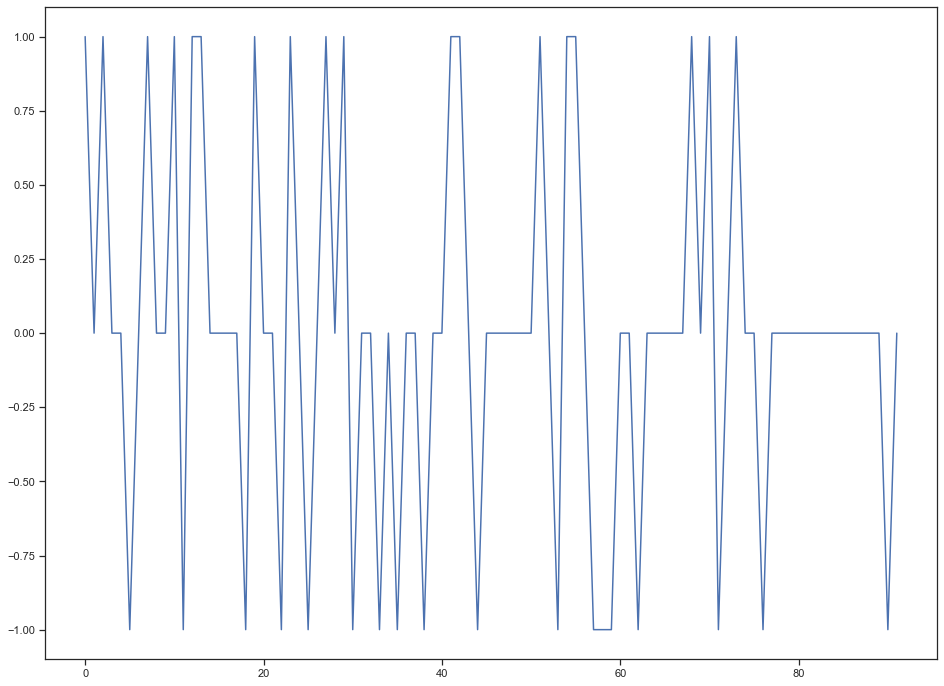

In [47]:
print('XGB MSE', mean([np.power(er, 2) for er in XGBClerror]))

figure(figsize=(16, 12))
# figure(figsize=(20, 15), dpi=80)
plt.plot([er[0] for er in XGBClerror])
print('XGB accuracy', metrics.accuracy_score(y_test, XGBClpred))
print(classification_report(y_test, XGBClpred))


In [48]:
# XGBCRFlassifier
XGBRFCl = XGBRFClassifier ()
tscv = TimeSeriesSplit(max_train_size=None, n_splits=len(X)-1)

print(tscv)

XGBRFClpred = []
XGBRFClerror = []
i = 0
for train_index, test_index in tscv.split(X.values):
    if len(train_index) < lenTrain:
        continue
    Xtrain, Xtest = X.loc[train_index], X.loc[test_index]
    ytrain, ytest = y.loc[train_index], y.loc[test_index]
    
#     #scaller
#     Xtrain = scaler.fit_transform(Xtrain)
#     Xtest = scaler.transform(Xtest)
    
    #fit the model
    XGBRFCl.fit(Xtrain, ytrain)
    
    #predict model
    y_pred = XGBRFCl.predict(Xtest)
    
    XGBRFClpred.append(y_pred[0])
    XGBRFClerror.append(ytest - y_pred)
    i += 1


TimeSeriesSplit(gap=0, max_train_size=None, n_splits=455, test_size=None)


XGBRF MSE 0.43478260869565216
XGBRF accuracy 0.5652173913043478
              precision    recall  f1-score   support

           0       0.64      0.62      0.63        55
           1       0.46      0.49      0.47        37

    accuracy                           0.57        92
   macro avg       0.55      0.55      0.55        92
weighted avg       0.57      0.57      0.57        92



C:\Users\Akhod\AppData\Local\Temp\ipykernel_1108\2538330539.py:1: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  print('XGBRF MSE', mean([np.power(er, 2) for er in XGBRFClerror]))


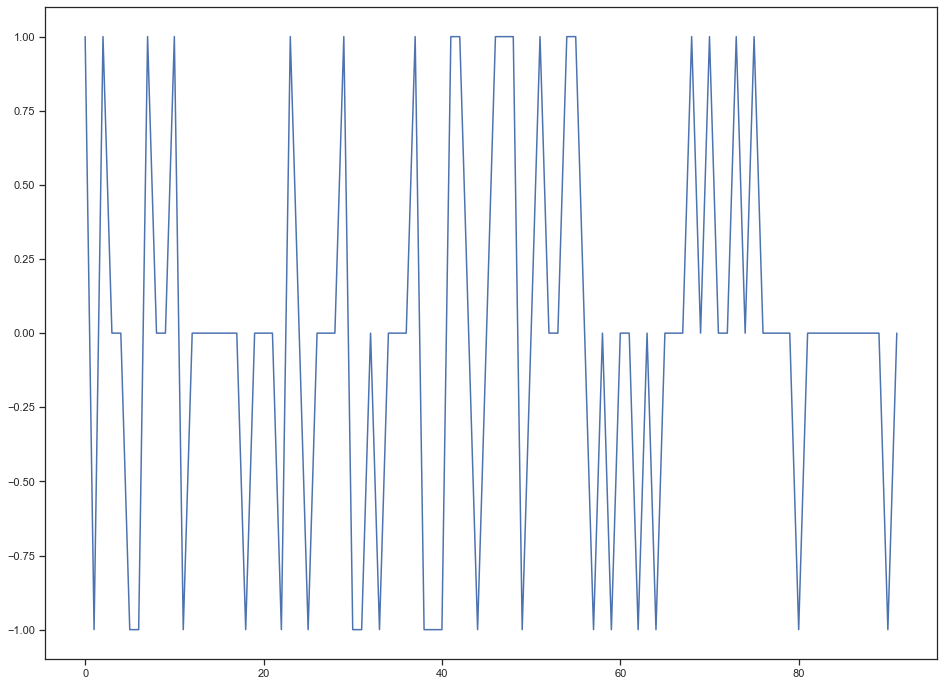

In [49]:
print('XGBRF MSE', mean([np.power(er, 2) for er in XGBRFClerror]))
figure(figsize=(16, 12))

plt.plot([er[0] for er in XGBRFClerror])
print('XGBRF accuracy', metrics.accuracy_score(y_test, XGBRFClpred))
print(classification_report(y_test, XGBRFClpred))


In [50]:

from sklearn.ensemble import RandomForestClassifier
RFCl = RandomForestClassifier ()
tscv = TimeSeriesSplit(max_train_size=None, n_splits=len(X)-1)

print(tscv)

RFClpred = []
RFClerror = []
i = 0
for train_index, test_index in tscv.split(X.values):
    if len(train_index) < lenTrain:
        continue
    Xtrain, Xtest = X.loc[train_index], X.loc[test_index]
    ytrain, ytest = y.loc[train_index], y.loc[test_index]
    
#     #scaller
#     X_train = scaler.fit_transform(X_train)
#     X_test = scaler.transform(X_test)
    
    #fit the model
    RFCl.fit(Xtrain, ytrain)
    y_pred = RFCl.predict(Xtest)
    RFClpred.append(y_pred[0])
    RFClerror.append(ytest - y_pred)
    i += 1


C:\Users\Akhod\AppData\Local\Temp\ipykernel_1108\1397977106.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFCl.fit(Xtrain, ytrain)


TimeSeriesSplit(gap=0, max_train_size=None, n_splits=455, test_size=None)


C:\Users\Akhod\AppData\Local\Temp\ipykernel_1108\1397977106.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFCl.fit(Xtrain, ytrain)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_1108\1397977106.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFCl.fit(Xtrain, ytrain)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_1108\1397977106.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFCl.fit(Xtrain, ytrain)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_1108\1397977106.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFCl.fit(Xtrain, ytrain)
C:\U

C:\Users\Akhod\AppData\Local\Temp\ipykernel_1108\1397977106.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFCl.fit(Xtrain, ytrain)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_1108\1397977106.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFCl.fit(Xtrain, ytrain)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_1108\1397977106.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFCl.fit(Xtrain, ytrain)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_1108\1397977106.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFCl.fit(Xtrain, ytrain)
C:\U

C:\Users\Akhod\AppData\Local\Temp\ipykernel_1108\1397977106.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFCl.fit(Xtrain, ytrain)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_1108\1397977106.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFCl.fit(Xtrain, ytrain)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_1108\1397977106.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFCl.fit(Xtrain, ytrain)
C:\Users\Akhod\AppData\Local\Temp\ipykernel_1108\1397977106.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFCl.fit(Xtrain, ytrain)
C:\U

C:\Users\Akhod\AppData\Local\Temp\ipykernel_1108\3820404798.py:1: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  print('Random Forest MSE', mean([np.power(er, 2) for er in RFClerror]))


Random Forest MSE 0.41304347826086957
DT accuracy 0.5869565217391305
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        55
           1       0.49      0.57      0.53        37

    accuracy                           0.59        92
   macro avg       0.58      0.58      0.58        92
weighted avg       0.60      0.59      0.59        92



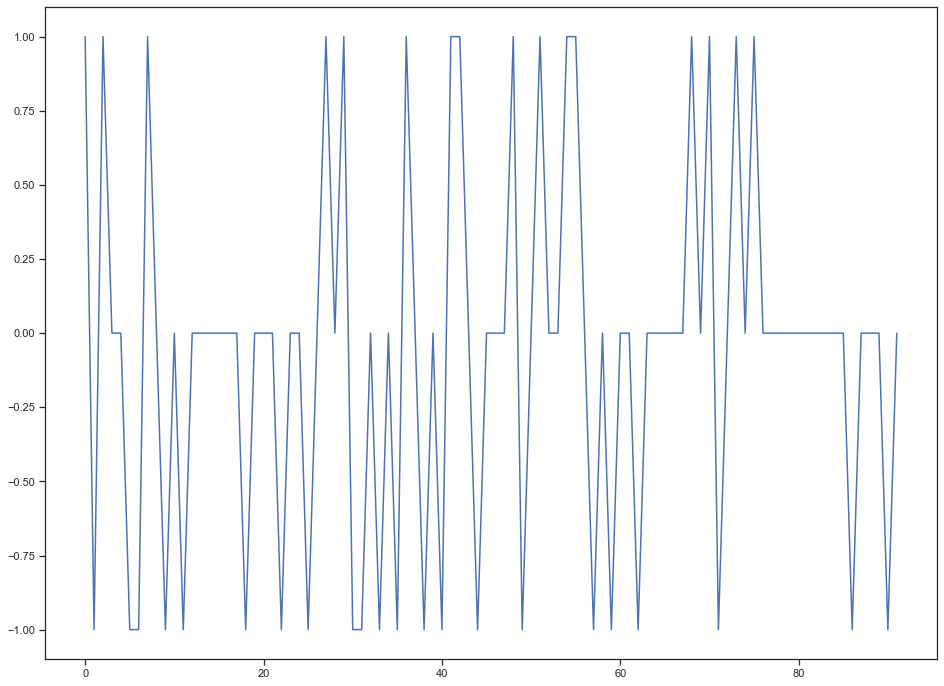

In [51]:
print('Random Forest MSE', mean([np.power(er, 2) for er in RFClerror]))
figure(figsize=(16, 12))

plt.plot([er[0] for er in RFClerror])
print('DT accuracy', metrics.accuracy_score(y_test, RFClpred))
print(classification_report(y_test, RFClpred))


In [53]:
tscv = TimeSeriesSplit(n_splits=3)
clf = GridSearchCV(lasso_regression, parameters, cv=tscv, scoring='neg_mean_squared_error',
                   verbose = 2, return_train_score=True, n_jobs = -1)